# DRAFT
# Filter pixel classifications results by segments

To Do:
- generalise
- multiband inputs to rsgislib.shpeherdseg?
- implement the tiled, multiprocessed version of shepherd seg
- custom statistics to zonal stats? https://pythonhosted.org/rasterstats/manual.html#user-defined-statistics
- instead of `zonal_stats_parallel` use RSGISLIB's raster-attribute-tables to assign pixel values to clumps?

In [1]:
import os
import sys
import gdal
import shutil
import xarray as xr
import geopandas as gpd
import subprocess as sp
from datacube.utils.cog import write_cog
from rsgislib.segmentation import segutils

sys.path.append('../Scripts')
from deafrica_classificationtools import HiddenPrints
from deafrica_spatialtools import xr_rasterize, xr_vectorize, zonal_stats_parallel


/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


# Analysis Parameters

In [2]:
pred_tif = 'prediction.tif'
tif_to_seg = 'NDVI_S1.tif'
min_seg_size=100 #in number of pixels

results = 'results/classifications/'


## Image segmentation

1. Generate image segments
2. Vectorize segments
3. Calculate zonal 'majority' statistic over vectorized segments
4. Rasterize segments using 'majority' as pixel values.
5. Write object-based classification to disk

### Automatically find the number of cpus

In [3]:
try:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-4:]))
except:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-3:]))

print('ncpus = '+str(ncpus))

ncpus = 31


## Run image segmentation

In [7]:
#store temp files somewhere
directory=results+'tmp_'
if not os.path.exists(directory):
    os.mkdir(directory)

tmp='tmp_/'

#inputs to image seg
kea_file = results+tif_to_seg[:-4]+'.kea'
segmented_kea_file = results+tif_to_seg[:-4]+'_segmented.kea'

#convert tiff to kea
gdal.Translate(destName=kea_file,
               srcDS=results+tif_to_seg,
               format='KEA',
               outputSRS='EPSG:6933')

#run image seg
print('image segmentation...')
with HiddenPrints():
    segutils.runShepherdSegmentation(inputImg=kea_file,
                                     outputClumps=segmented_kea_file,
                                     tmpath=results+tmp,
                                     numClusters=60,
                                     minPxls=min_seg_size)

## Vectorise segments

In [ ]:
#open segments
da=xr.open_rasterio(segmented_kea_file).squeeze()

#convert to polygons and export to disk
print('   writing segments to shapefile...')
with HiddenPrints():
    gdf_seg = xr_vectorize(da, attribute_col='attribute')
print("   Number of segments: "+str(len(gdf_seg)))
gdf_seg.to_file(results+tif_to_seg[:-4]+'_segmented.shp')

## Zonal statistics

In [8]:
#calculate zonal-stats
print('zonal statistics...')
zonal_stats_parallel(shp=results+tif_to_seg[:-4]+'_segmented.shp',
       raster=results+pred_tif,
       statistics=['majority'],
       out_shp=results+tmp+"zonal_stats.shp",
       ncpus=ncpus if ncpus<25 else 25, #otherwise too much mem consumption
       nodata=-1
           )


   zonal statistics...


/env/lib/python3.6/site-packages/fiona/collection.py:352: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)


## Rasterize results & export result

In [ ]:
#rasterize the zonal-stats
with HiddenPrints():
    gdf_zs=gpd.read_file(results+tmp+"zonal_stats.shp")
    predict_zs = xr_rasterize(gdf_zs, da, attribute_col='majority')

#write to disk
write_cog(predict_zs, results+ 'prediction_object.tif', overwrite=True)

#remove the tmp folder
shutil.rmtree(results+tmp)
os.remove(kea_file)
os.remove(segmented_kea_file)

## Plot

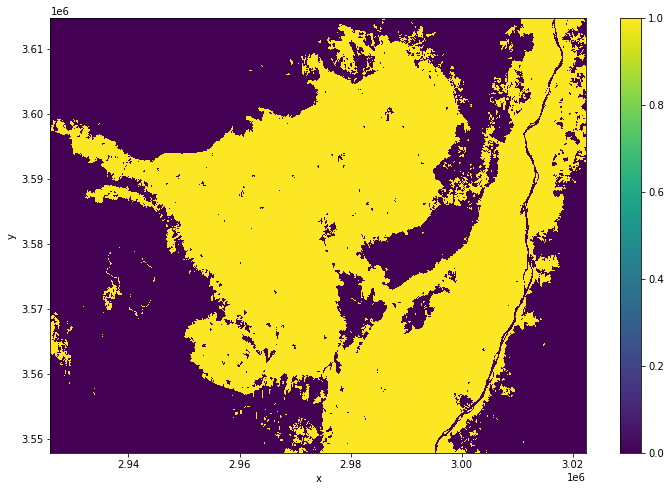

In [9]:
predict_zs.plot(size=8);

***

## Testing object filtering with RSGISLIB

`rsgislib.rastergis.populateRATWithMode`
https://www.rsgislib.org/rsgislib_rastergis.html?#rsgislib.rastergis.ratutils.populateImageStats

In [ ]:
# from rsgislib.rastergis import populateRATWithMode
# from rsgislib.rastergis import ratutils
# from rsgislib import rastergis
# from rios import rat

# populateRATWithMode(valsimage=results+'Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'.tif',
#                    clumps=results+'Eastern_tile_'+g_id+'_segmented.kea',
#                    outcolsname ='mode')

# ratutils.populateImageStats(
#               inputImage=results+'Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'.tif',
#               clumpsFile=results+'Eastern_tile_'+g_id+'_segmented.kea',
#               calcSum=True
# )

# # Attribute segments with class
# rastergis.strClassMajority(clumpsFile=results+'Eastern_tile_'+g_id+'_segmented.kea',
#                            infoclumps=results+'Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'.tif',
#                            baseclasscol= 'maj',
#                            infoclasscol='maj',
#                            ignoreZero=False
#                           )

# y = rat.readColumn(results+'Eastern_tile_'+g_id+'_segmented.kea',
#                    'maj') 

***
## RSGISlib Shepherd Seg tiled examples

### single cpu, tiled

In [ ]:
%time
# #run the segmentation
with HiddenPrints():
    tiledsegsingle.performTiledSegmentation(kea_file,
                                    segmented_kea_file,
                                    tmpDIR=temp,
                                    numClusters=60,
                                    validDataThreshold=validDataTileFraction, 
                                    tileWidth=width,
                                    tileHeight=height,
                                    minPxls=9)

In [ ]:
# Attribute segments with zonal mean of input image and output as geotiff
meanImage(tiff_to_segment, segmented_kea_file, segments_zonal_mean, "GTIFF",rsgislib.TYPE_32FLOAT)

### n cpus, tiled

In [ ]:
# %time
#run the segmentation
with HiddenPrints():
    tiledSegParallel.performTiledSegmentation(kea_file,
                                segmented_kea_file,
                                tmpDIR=temp,
                                numClusters=60,
                                validDataThreshold=validDataTileFraction, 
                                tileWidth=width,
                                tileHeight=height,
                                minPxls=9,
                                ncpus=ncpus)

# Attribute segments with zonal mean of input image and output as geotiff
meanImage(tiff_to_segment, segmented_kea_file, segments_zonal_mean, "GTIFF",rsgislib.TYPE_32FLOAT)

Dask parallel zonal stats (seems really slow)